<a href="https://colab.research.google.com/github/bhuvanikavijay/CodSoft-tasks-/blob/main/CodSoft_Task_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import cv2
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
def generate_image_pairs(images, labels):
    # Generate index for each label
    unique_labels = np.unique(labels)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels) if
                                       label == curr_label])

    # Generate image pairs and labels
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images):
        pos_indices = label_wise_indices.get(labels[index])
        pos_image = images[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels != labels[index])
        neg_image = images[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)

    return np.array(pair_images), np.array(pair_labels)

In [3]:
faces = '../input/olivetti/olivetti_faces.npy'
faces_targets = '../input/olivetti/olivetti_faces_target.npy'

In [5]:
!pip install scikit-learn
from sklearn.datasets import fetch_olivetti_faces

# Fetch the Olivetti faces dataset
faces = fetch_olivetti_faces()

# Access the images and labels
face_images = faces.images
face_labels = faces.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [6]:
target_shape = face_images[0].shape

In [7]:
images_dataset, labels_dataset = generate_image_pairs(face_images, face_labels)
images_dataset, labels_dataset = shuffle(images_dataset, labels_dataset)

In [8]:
def visualize(image_pairs, labels, n = 5, title = "Image Pair Examples"):
    """ Visualize a few pairs """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    plt.title(title)
    axs = fig.subplots(n, 2)
    for i in range(n):
        show(axs[i, 0], image_pairs[i][0])
        show(axs[i, 1], image_pairs[i][1])

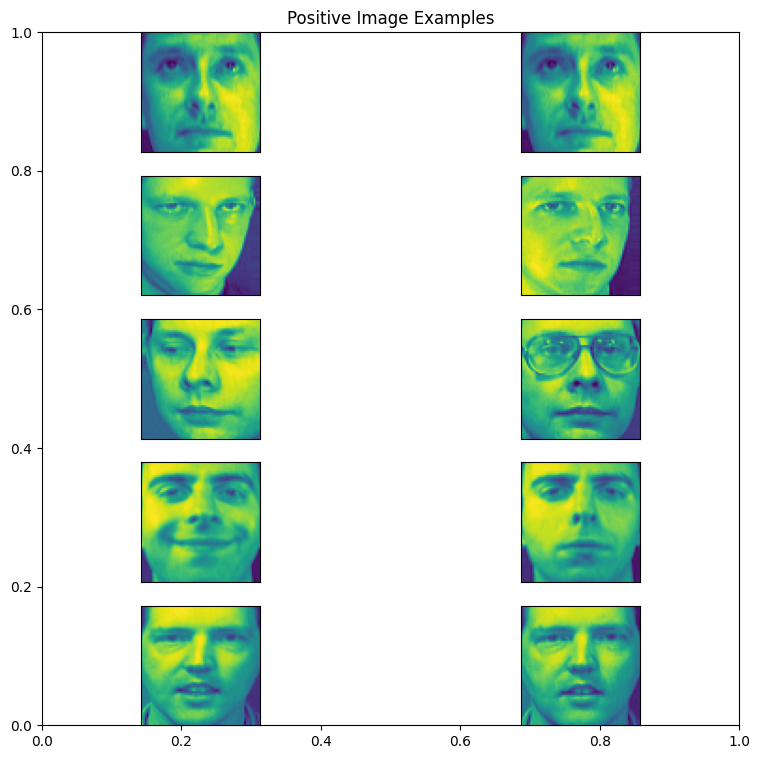

In [9]:
n = 5
indices = np.where(labels_dataset == 1)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Positive Image Examples")

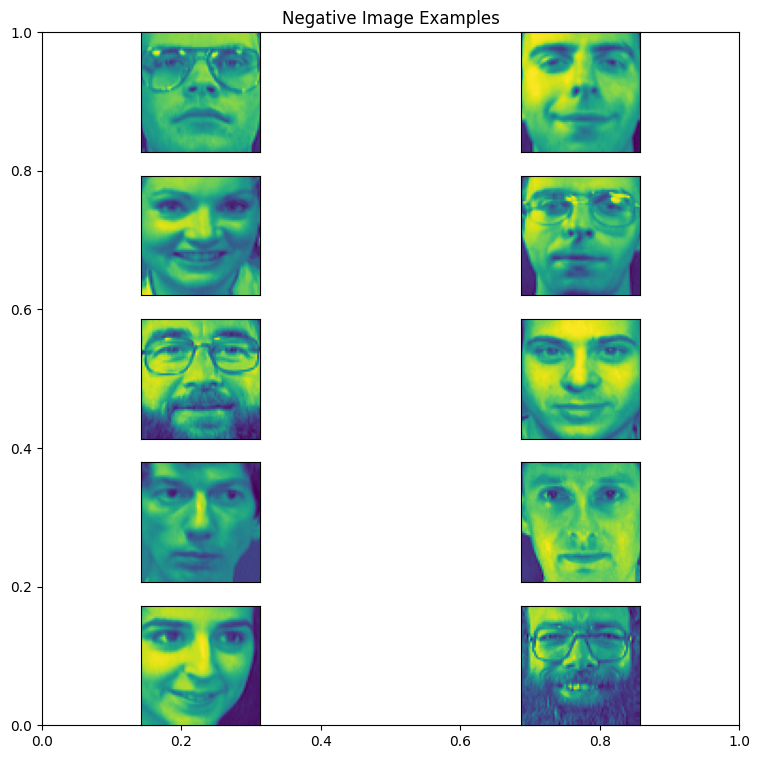

In [ ]:
n = 5
indices = np.where(labels_dataset == 0)[:n]
visualize(images_dataset[indices], labels_dataset[indices],
          title = "Negative Image Examples")

In [10]:
inputs = layers.Input((64, 64, 1))

x = layers.Conv2D(64, (10, 10), padding="same", activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (7, 7), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (4, 4), padding="same", activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, (4, 4), padding="same", activation="relu")(x)
fcOutput = layers.Flatten()(x)
fcOutput = layers.Dense(4096, activation = "relu")(fcOutput)
outputs = layers.Dense(1024, activation = "sigmoid")(fcOutput)

embedding = Model(inputs, outputs, name = "Embedding")

In [11]:
import tensorflow.keras.backend as K

In [12]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)

    return loss

In [13]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance
    between the embeddings
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, compare):
        sum_squared = K.sum(K.square(anchor - compare), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_squared, K.epsilon()))

In [14]:
anchor_input = layers.Input(name="anchor", shape=target_shape + (1,))
compare_input = layers.Input(name="compare", shape=target_shape + (1,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(compare_input),
)

outputs = layers.Dense(1, activation = "sigmoid") (distances)

siamese_model = Model(
    inputs=[anchor_input, compare_input], outputs=outputs
)

In [15]:
siamese_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = siamese_model.fit([images_dataset[:, 0, :], images_dataset[:, 1, :]], labels_dataset,
                            epochs=150, validation_split = 0.2, batch_size = 64)

Epoch 1/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 13s/step - accuracy: 0.4870 - loss: 0.7017 - val_accuracy: 0.5063 - val_loss: 0.6933
Epoch 2/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 137s 12s/step - accuracy: 0.5030 - loss: 0.6933 - val_accuracy: 0.5063 - val_loss: 0.6933
Epoch 3/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 12s/step - accuracy: 0.5141 - loss: 0.6931 - val_accuracy: 0.5063 - val_loss: 0.6933
Epoch 4/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 146s 13s/step - accuracy: 0.5094 - loss: 0.6931 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 5/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 13s/step - accuracy: 0.5123 - loss: 0.6931 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 6/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 13s/step - accuracy: 0.4886 - loss: 0.6932 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 7/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 13s/step - accuracy: 0.4922 - loss: 0.6932 - val_accuracy: 0.5063 - val_loss: 0.6931
Epoch 8/150
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 13s/step - accuracy: 0.5214 - loss: 0.6930 - val_accu

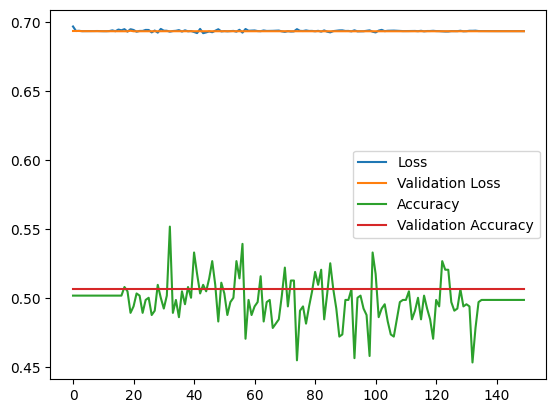

In [16]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Loss", "Validation Loss", "Accuracy", "Validation Accuracy"])

In [17]:
def test_visualize(images, n = 5):
    """ Visualize a few images """

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))
    axs = fig.subplots(1, n)
    for i in range(n):
        show(axs[i], images[i])

In [18]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

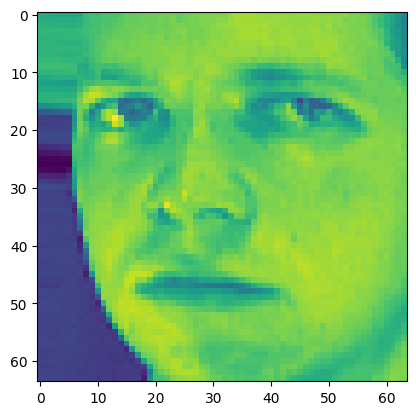

In [19]:
plt.imshow(test_image)

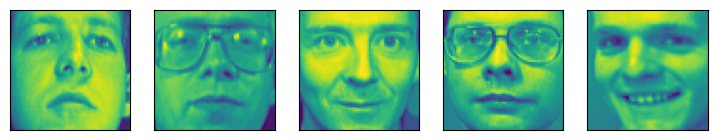

In [20]:
test_visualize(compare_images)

In [21]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [22]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


In [23]:
print(score)

[[0.4982352]
 [0.4982352]
 [0.4982352]
 [0.4982352]
 [0.4982352]]


In [24]:
test_indices = [0, 1, 2, 3, 4]
test_index = random.sample(range(10, 20), 1)[0]
test_image = face_images[test_index]

compare_images = []
for i in range(5):
    index = random.sample(range(i * 10, (i + 1) * 10), 1)[0]
    image = face_images[index]
    compare_images.append(image)

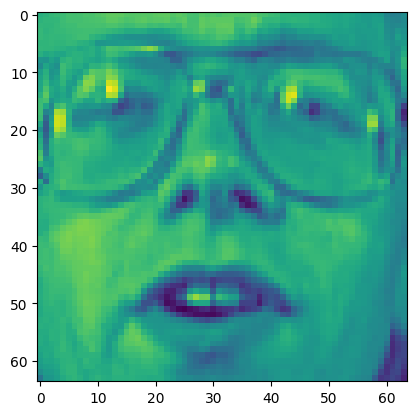

In [25]:
plt.imshow(test_image)

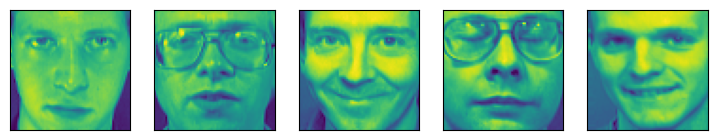

In [26]:
test_visualize(compare_images)

In [27]:
image_pairs = []

for image in compare_images:
    image_pairs.append((test_image, image))

image_pairs = np.array(image_pairs)

In [28]:
score = siamese_model.predict([image_pairs[:, 0, :], image_pairs[:, 1, :]])
print(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
[[0.4982352]
 [0.4982352]
 [0.4982352]
 [0.4982352]
 [0.4982352]]
